In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<div dir='rtl'>
    <h1>گزارش تمرین عملی دوم</h1>
    <h2>مشاهده و تمیز کردن داده‌ها</h2>
    ابتدا داده‌ها را لود می‌کنیم و با مشاهده نوع داده‌های هر ستون می‌بینیم که کدام از آن‌ها را باید تبدیل به one hot vector کنیم.
</div>

In [2]:
df = pd.read_excel(r'ToyotaCorolla.xls', sheet_name='data')
df.dtypes

Id                    int64
Model                object
Price                 int64
Age_08_04             int64
Mfg_Month             int64
Mfg_Year              int64
KM                    int64
Fuel_Type            object
HP                    int64
Met_Color             int64
Color                object
Automatic             int64
CC                    int64
Doors                 int64
Cylinders             int64
Gears                 int64
Quarterly_Tax         int64
Weight                int64
Mfr_Guarantee         int64
BOVAG_Guarantee       int64
Guarantee_Period      int64
ABS                   int64
Airbag_1              int64
Airbag_2              int64
Airco                 int64
Automatic_airco       int64
Boardcomputer         int64
CD_Player             int64
Central_Lock          int64
Powered_Windows       int64
Power_Steering        int64
Radio                 int64
Mistlamps             int64
Sport_Model           int64
Backseat_Divider      int64
Metallic_Rim        

<div dir="rtl">
چون در سوال گفته شده که از ستون‌های model و id استفاده نکنیم پس این ستون ‌ها را حذف می‌کنیم. سپس با توجه به نوع ستون‌های باقی‌مانده می‌بینیم که با ستون‌های Fuel_type و Color را تبدیل به one hot vector کنیم.
</div>

In [3]:
df = df.drop(['Id', 'Model'], axis=1)

In [4]:
one_hot_fuel = pd.get_dummies(df['Fuel_Type'])
df = df.drop('Fuel_Type',axis = 1)
df = df.join(one_hot_fuel)

one_hot_color = pd.get_dummies(df['Color'])
df = df.drop('Color',axis = 1)
df = df.join(one_hot_color)

df.columns

Index(['Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'HP', 'Met_Color',
       'Automatic', 'CC', 'Doors', 'Cylinders', 'Gears', 'Quarterly_Tax',
       'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'Guarantee_Period', 'ABS',
       'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer',
       'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering',
       'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar', 'CNG', 'Diesel',
       'Petrol', 'Beige', 'Black', 'Blue', 'Green', 'Grey', 'Red', 'Silver',
       'Violet', 'White', 'Yellow'],
      dtype='object')

<div dir='rtl'>
    <h2>نرمالایز و جدا کردن train و test و validation</h2>
    در این قسمت داده‌ّای هر ستون را normalize می‌کنیم. به این صورت که هر مقدار آن ستون را بر نرم آن ستون تقسیم می‌کنیم. <br>
    حال برای جدا کردن train و test و validation از تابع find_train_test که در آن با استفاده از sample داده‌ها را جدا می‌کند استفاده می‌کنیم.
</div>

In [5]:
def normalize_columns(df):
    result = df.copy()
    for f in df.columns:
        result[f] = df[f] / np.linalg.norm(df[f])
    return result

def find_train_test(df):
    train = df.sample(frac=0.7, random_state=0)   
    rest = df.drop(train.index)
    validation = rest.sample(frac=0.5, random_state=0)
    test = rest.drop(validation.index)
    return train, test, validation


df = normalize_columns(df)
train, test, validation = find_train_test(df)
print("Train data:\n", train.shape)
print("Validation data: \n",validation.shape)
print("Test data:\n", test.shape)

Train data:
 (1005, 48)
Validation data: 
 (216, 48)
Test data:
 (215, 48)


<div dir='rtl'>
    <h2>پیاده سازی SGD</h2>
    در این قسمت SGD را که از رابطه زیر پیروی می‌کند پیاده‌سازی می‌کنیم.
</div>

\begin{equation}
w_{i+1} = w_i - \eta \frac{1}{|B|}\sum_{x_j\in B} -2x_j(y_j - wx_j)
\end{equation}

W_sgd =  [[0.02770547 0.03238358 0.03908032 0.02382104 0.04063103 0.03247081
  0.00968063 0.03910233 0.03938862 0.03905706 0.03908341 0.0372558
  0.03993982 0.02780663 0.03626975 0.03542612 0.0381868  0.03833436
  0.03504753 0.03459312 0.02632384 0.03766432 0.03185397 0.0338896
  0.03368843 0.03844836 0.01236318 0.02058462 0.02357915 0.03327997
  0.01879021 0.01244355 0.0030776  0.01236798 0.00137209 0.01421403
  0.03649309 0.00056487 0.01490972 0.01787323 0.01192288 0.02418343
  0.01347441 0.0118615  0.00138709 0.00247534 0.0021339 ]]


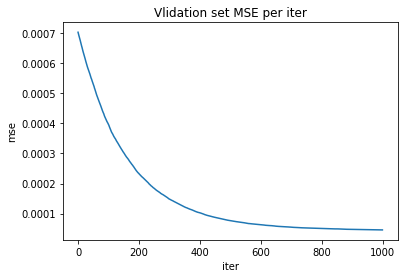

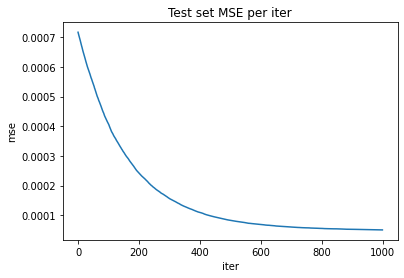

MSE test set with simple SGD: 5.1040340290799634e-05
MSE validation set with simple SGD: 4.548692753071634e-05


In [6]:
def mean_square_error(y, y_predict):
    return np.square(np.subtract(y, y_predict)).mean() 


def SGD(data, learning_rate, iterations, k=10):
    w = np.zeros(shape=(1, data.shape[1]-1))
    mse_validation = []
    mse_test = []
    x_validation = validation.drop('Price',axis=1)
    x_test = test.drop('Price',axis=1)
    
    for i in range(iterations):
        sample = data.sample(k)
        y = np.array(sample['Price'])
        x = np.array(sample.drop('Price',axis=1))
        w_grad = np.zeros(shape=(1,data.shape[1]-1))
        
        for j in range(k):
            w_grad += (-2) * x[j] * (y[j] - (np.dot(w, x[j])))
        w_grad = w_grad/k 
        w = w - learning_rate * w_grad
        mse_validation.append(mean_square_error(validation['Price'].values, np.dot(w, x_validation.values.T)))
        mse_test.append(mean_square_error(test['Price'].values, np.dot(w, x_test.values.T)))
    return w, mse_test, mse_validation

iterations = 1000
w_sgd, mse_test, mse_validation = SGD(train, learning_rate = 0.1, iterations = iterations)
print("W_sgd = ", w_sgd)
plt.plot([j for j in range(iterations)], mse_validation)
plt.title("Vlidation set MSE per iter")
plt.xlabel("iter")
plt.ylabel("mse")
plt.show()
    
plt.plot([j for j in range(iterations)], mse_test)
plt.title("Test set MSE per iter")
plt.xlabel("iter")
plt.ylabel("mse")
plt.show()

print("MSE test set with simple SGD:", mse_test[-1])
print("MSE validation set with simple SGD:", mse_validation[-1])

<div dir="rtl">
می‌بینیم که با learning rate = 0.1 و ۱۰۰۰ iteration خطا روی داده‌های test و validation به اردر e^-5 رسیده است. 
</div>

<div dir='rtl'>
    <h2>پیاده‌سازی ridge regression</h2>
    برای پیاده سازی ridge regressor دو راه وجود دارد: iterative و close form.  در این قسمت هر دو پیاده سازی وجود دارد. کد در این حالت به دلیل دقیق‌تر بودن close form با فرم بسته اجرا می‌شود. در صورتی که بخواهیم با فرم ایتریتیو اجرا کنیم کافیست تابع iterative_ridge_regressor را فراخوانی کنیم. 
</div>

In [8]:
def iterative_ridge_regressor(x, y, l2, learning_rate, iterations):
    w = np.zeros(shape=(1, x.shape[1]))
    for i in range(iterations):
        w_grad = np.zeros(shape=(1, x.shape[1]))
        for j in range(x.shape[0]):
            w_grad += 2 * (l2 * w - (x[j] * (y[j] - (np.dot(w, x[j])))))
        w_grad = w_grad / x.shape[0]
        w = w - learning_rate * w_grad
    return w

def find_optimal_w(X, y, l2):
    a = np.dot(X.T, X)
    b = np.dot(X.T, y)
    w = np.dot(np.linalg.inv(np.add(a, l2 * np.identity(X.shape[1]))), b)
    return w


def run_ridge(l2):
    y = np.array(train['Price'])
    x = np.array(train.drop('Price',axis=1))
    w_ridge = find_optimal_w(x, y, l2)
#     w_ridge = iterative_ridge_regressor(x, y, l2, 0.1, 1000)
    print("l2 = ", l2)
    print("W_ridge = ", w_ridge)
    print("MSE test set with ridge regression", 
          mean_square_error(test['Price'].values, np.dot(w_ridge, test.drop('Price',axis=1).T)))
    print("MSE validation set with ridge regression",
          mean_square_error(validation['Price'].values, np.dot(w_ridge, validation.drop('Price',axis=1).T)))
    print("-------------------------------")
run_ridge(l2 = 1)
run_ridge(l2 = 0)

l2 =  1
W_ridge =  [ 0.00897126  0.02653375  0.04032696 -0.00187315  0.04532467  0.02715673
  0.01159725  0.04002645  0.04306534  0.04025302  0.04025917  0.04158365
  0.04325319  0.02958445  0.03362758  0.04787609  0.03887025  0.03671941
  0.03227292  0.03618196  0.05533892  0.06087428  0.04407342  0.03229275
  0.03312926  0.03749082  0.01015703  0.01038604  0.02657065  0.02637963
  0.01321171  0.01058896  0.00304056 -0.00163127 -0.00235339  0.01513684
  0.03787673 -0.00065342  0.01281181  0.01751535  0.00975123  0.03042725
  0.01212521  0.0152641   0.00292594 -0.00012739  0.0036673 ]
MSE test set with ridge regression 3.8738615048045684e-05
MSE validation set with ridge regression 3.3322774613354915e-05
-------------------------------
l2 =  0
W_ridge =  [ 5.42598059e+09  5.96670043e+08  2.20841779e+12  7.50396304e-01
 -1.49761919e+01  1.04589694e-01 -6.47539043e-01 -2.53196847e-01
 -5.29662390e+00 -2.47420947e+11 -7.39504623e+00 -6.93427754e-01
  1.12447464e+02  1.72770512e-01  1.3554

<div dir="rtl">
نتایج نشان می‌دهند که با قرار دادن l2=1 اردر خطا روی داده‌ی test و validation همان e^-5 که اردر خطای SGD است می‌شود. در حالی که اگر l2 را برابر با صفر بگذاریم یعنی در واقع regularization term را حذف کرده و همان sum of squares را به عنوان loss function داریم که می‌خواهیم minimize کنیم. نتایج به دست آمده با قرار دادن l2 برابر با صفر نشان می‌دهد که خطا روی داده test و validation بیشتر از حالتی است که l2 برابر با ۱ بوده است.
   <br>
    مزایای ridge regression:
    <li> خطای کمتری نسبت به simple regression دارد.</li>
    <li>با کنترل کردن اندازه w ها از بزرگ شدن آن‌ها و overfitting جلوگیری می‌کند.</li>
    <li> در صورتی که feature ها correlation زیادی با هم داشته باشند با توجه به فرم بسته با اضافه کردن مقدار لاندا به درایه‌های قطری ماتریس X^TX دترمینان آن را افزایش داده و به اصطلاح آن را وارن پذیر تر می‌کند.</li>
</div>

<div dir='rtl'>
    در این قسمت برای پیاده سازی SGD از loss function زیر استفاده شده است.
</div>

\begin{equation}
loss = \| Y- Xw \| _1
\end{equation}

<div dir='rtl'>
    برای این loss function فرمول پیاده‌سازی SGD به شکل زیر خواهد شد. این فرمول برای پیاده‌سازی تابع SGD_2 استفاده شده است.
</div>

\begin{equation}
w_{i+1} = w_i - \eta \frac{1}{|B|}\sum_{x_j\in B} -x_j \times sign(y_j - wx_j)
\end{equation}

W_sgd_2 [[-0.12880307 -0.01514198  0.08286519 -0.14984515  0.10192591 -0.00321246
   0.00559017  0.06071643  0.08793503  0.08233365  0.08918756  0.09763238
   0.10051362  0.02226922  0.03569353  0.08074489  0.02516385  0.02410522
   0.00869079  0.03479096  0.09        0.07730845  0.0310383   0.01974933
   0.01584075  0.04803845  0.00069007 -0.03175533  0.01974901  0.00721662
   0.01166424  0.00415029 -0.015      -0.01702129  0.00242536  0.03212877
   0.07622471  0.          0.03545516  0.03804405  0.020226    0.04553484
   0.03478609  0.02444465  0.005       0.00718421  0.        ]]


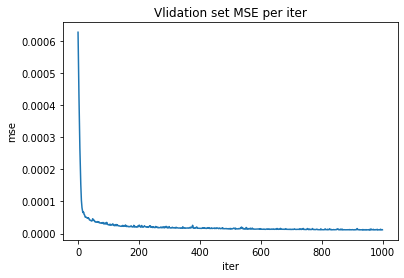

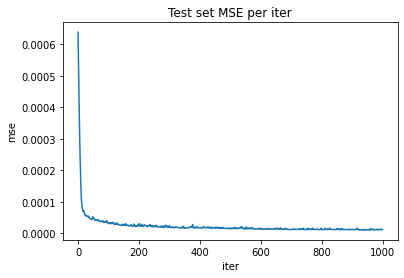

MSE test set : 1.2465578088465931e-05
MSE validation: 1.1937265118993964e-05


In [9]:
def SGD_2(data, learning_rate, iterations, k=10):
    w = np.zeros(shape=(1, data.shape[1]-1))
    mse_validation = []
    mse_test = []
    x_validation = validation.drop('Price',axis=1)
    x_test = test.drop('Price',axis=1)
    
    for i in range(iterations):
        sample = data.sample(k)
        y = np.array(sample['Price'])
        x = np.array(sample.drop('Price',axis=1))
        w_grad = np.zeros(shape=(1,data.shape[1]-1))
        
        for j in range(k):
            w_grad -= x[j] * np.sign(y[j] - (np.dot(w, x[j])))
        w_grad = w_grad/k 
        w = w - learning_rate * w_grad
        mse_validation.append(mean_square_error(validation['Price'].values, np.dot(w, x_validation.values.T)))
        mse_test.append(mean_square_error(test['Price'].values, np.dot(w, x_test.values.T)))
    return w, mse_test, mse_validation

iterations = 1000
w_sgd_2, mse_test_2, mse_validation_2 = SGD_2(train, learning_rate = 0.1, iterations = iterations)
print("W_sgd_2", w_sgd_2)
plt.plot([j for j in range(iterations)], mse_validation_2)
plt.title("Vlidation set MSE per iter")
plt.xlabel("iter")
plt.ylabel("mse")
plt.show()
    
plt.plot([j for j in range(iterations)], mse_test_2)
plt.title("Test set MSE per iter")
plt.xlabel("iter")
plt.ylabel("mse")
plt.show()

print("MSE test set :", mse_test_2[-1])
print("MSE validation:", mse_validation_2[-1])

<div dir='rtl'>
    نتیجه به دست آمده از قسمت اول و سوم نشان می‌دهد که اردر خطای هر دو loss function یکسان است ولی مقدار خطای روش سوم کمتر است. زیرا w به دست آمده از این روش به w_optimal نزدیک تر است. پس می‌توان گفت برای این مجموعه داده استفاده از loss function قسمت سوم بهتر از loss function قسمت اول است.
</div>